In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import statsmodels.api as sm
import joblib
import os

In [2]:
# Load in Cluster 1 DataFrame
df = pd.read_csv("df_cluster_1.csv")
df.head()

,ROA(C) before interest and depreciation before interest,Long-term Liability to Current Assets,Current Ratio,Inventory/Current Liability,Total expense/Assets,Operating Expense Rate,Long-term fund suitability ratio (A),Current Asset Turnover Rate,Tax rate (A),Revenue Per Share (Yuan ¥),...,Operating Gross Margin,Cash flow rate,Average Collection Days,Degree of Financial Leverage (DFL),Accounts Receivable Turnover,Net Value Growth Rate,Realized Sales Gross Profit Growth Rate,Cluster,Bankrupt?,Index
0,-0.910898,0.094090,-0.358774,-0.057362,-0.504669,1.424170,-0.750102,2.125917,-1.045346,-0.091504,...,-0.818583,-0.278810,-0.649563,-0.121166,0.023336,-0.194584,-0.170329,1,0,0
1,-0.377304,-0.173849,-0.566183,0.168012,-1.161883,1.422553,0.190184,-0.470732,-1.045346,0.443802,...,-0.349573,-0.874608,-0.701320,0.025172,0.063937,-0.069073,-0.014976,1,0,3
2,0.065604,-0.270475,-0.434480,-0.296268,0.676207,1.417704,0.505804,2.126122,2.136349,1.675083,...,-0.495731,-0.305812,-0.433154,-0.072078,-0.079665,-0.198655,-0.098700,1,0,4
3,0.661580,-0.083179,-0.456576,7.916045,-1.369075,1.407511,2.166725,-0.470885,-0.319093,1.523739,...,-0.634386,-0.399691,-0.030905,-0.081939,-0.162270,0.268158,0.238657,1,0,5
4,-0.674833,-0.232832,-0.575451,0.020871,-1.925878,1.391565,-0.409082,-0.470516,1.909433,-0.875284,...,-0.812559,-0.320968,0.889433,1.241834,-0.226496,-0.150226,0.112130,1,0,6


In [3]:
# Let's reduce the number of features by running OLS and only keeping significant features 

X = df.drop(columns=['Cluster','Bankrupt?',"Index"])
y = df["Bankrupt?"].values
X_with_const = sm.add_constant(X)

# Fit OLS model
ols = sm.OLS(y, X_with_const).fit()

#print(ols.summary())

Let's reduce our number of features to only keep those with a p-value of less than 0.01.

In [4]:
pvals = ols.pvalues
pvals = pvals.drop("const")

# Keep only features with p-value < 0.01
selected_features = pvals[pvals < 0.01].index.tolist()

print(f"Selected {len(selected_features)} features:\n", selected_features)
X_selected = X[selected_features]

Selected 4 features:
 [' Total expense/Assets', ' Revenue Per Share (Yuan ¥)', ' Revenue per person', ' Total debt/Total net worth']


Before running our stacked model, we will see how each base model performs individually. 

Training accuracy (meta-model): 1.000

Number of features used: 4


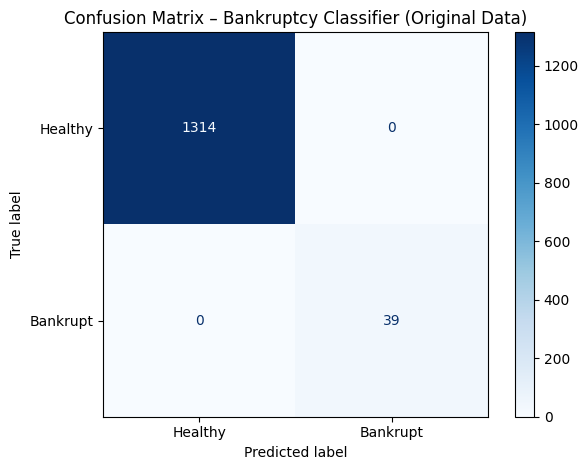

In [5]:
# --- base learners ---
base_learners = [
    ('svc', SVC(kernel='rbf', C=5, probability=True,class_weight='balanced', random_state=42)),
    ('dt', DecisionTreeClassifier(max_depth=20, class_weight='balanced', random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42))
]

# --- meta learner ---
meta_learner = MLPClassifier(
    hidden_layer_sizes=(50,), activation='relu', max_iter=500, random_state=42
)


# --- stacking model ---
stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=10,      
    passthrough=False    
)

# --- fit stacking model directly on original X_selected, y ---
stacking_clf.fit(X_selected, y)

# --- get training accuracy (for Table 3) ---
train_acc_meta = stacking_clf.score(X_selected, y)
print(f"Training accuracy (meta-model): {train_acc_meta:.3f}")

# --- get number of features ---
n_features_used = X_selected.shape[1]
print(f"\nNumber of features used: {n_features_used}")

# predict on the full training data
y_pred_full = stacking_clf.predict(X_selected)

# plot confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y, y_pred_full,
    display_labels=["Healthy", "Bankrupt"],
    cmap="Blues", values_format="d"
)
plt.title("Confusion Matrix – Bankruptcy Classifier (Original Data)")
plt.tight_layout()
plt.show()



In [6]:
#PRINT ACCURACY_SCORE[TT(TF)] FOR META MODEL
acc = accuracy_score(y, y_pred_full)

# Compute TT (true bankrupt predicted bankrupt) and TF (false bankrupt predicted healthy)
TT = ((y == 1) & (y_pred_full == 1)).sum()  # True Bankrupt predicted as Bankrupt
TF = ((y == 1) & (y_pred_full == 0)).sum()  # True Bankrupt predicted as Healthy

# Print final output in your desired format
print(f"\nAccuracy (Meta Model) [TT(TF)]: {acc:.3f} [{TT}({TF})]")


Accuracy (Meta Model) [TT(TF)]: 1.000 [39(0)]


Now let's calculate and print the base models' individual accuracies, cumulative average accuracies, and print the confusion matrix.

Training accuracy (SVC): 0.888 [38(151)]


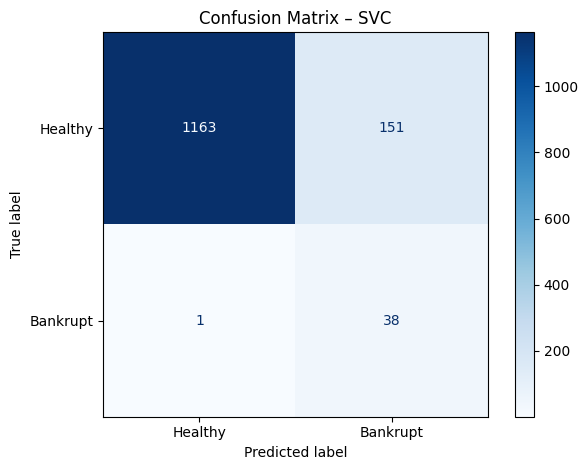

Training accuracy (Decision Tree): 1.000 [39(0)]


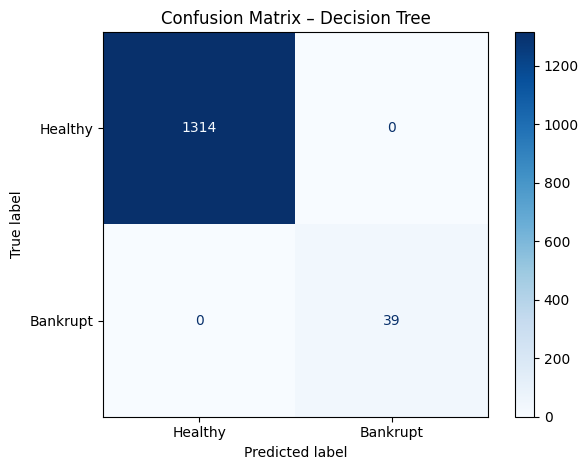

Training accuracy (Random Forest): 1.000 [39(0)]


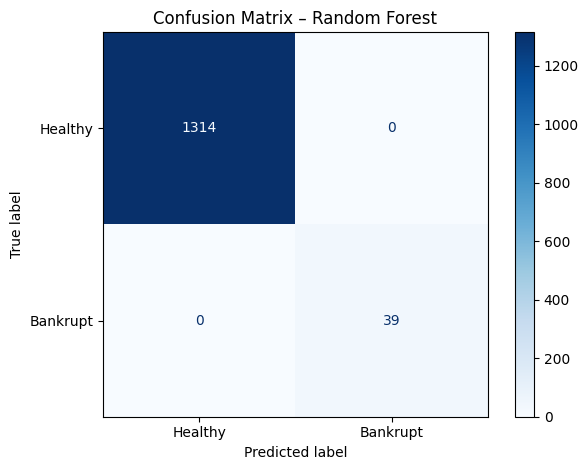


Average training accuracy of base models: 0.963
Average TT(TF): 38.7(50.3)


In [7]:
# claculate and print base models' average Accuracy score and [TT(TF)]

base_model_accuracies = []
base_model_TT = []
base_model_TF = []

def evaluate_model(model, X, y, model_name):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    base_model_accuracies.append(acc)
    base_model_TT.append(tp)
    base_model_TF.append(fn)
    
    print(f"Training accuracy ({model_name}): {acc:.3f} [{tp}({fn})]")
    
    # Plot confusion matrix
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Bankrupt"]).plot(cmap="Blues")
    plt.title(f"Confusion Matrix – {model_name}")
    plt.tight_layout()
    plt.show()

# --- evaluate each base model ---
evaluate_model(stacking_clf.named_estimators_['svc'], X_selected, y, 'SVC')
evaluate_model(stacking_clf.named_estimators_['dt'], X_selected, y, 'Decision Tree')
evaluate_model(stacking_clf.named_estimators_['rf'], X_selected, y, 'Random Forest')

# --- compute and print average accuracy ---
avg_base_acc = np.mean(base_model_accuracies)
print(f"\nAverage training accuracy of base models: {avg_base_acc:.3f}")

avg_TT = np.mean(base_model_TT)
avg_TF = np.mean(base_model_TF)
print(f"Average TT(TF): {avg_TT:.1f}({avg_TF:.1f})")

In [8]:
# Save Cluster 1 data

new_train_df = df[[' Total expense/Assets', ' Revenue Per Share (Yuan ¥)', ' Revenue per person', ' Total debt/Total net worth',"Cluster","Bankrupt?","Index"]]

os.makedirs("saved_models", exist_ok=True)

# --- 1. Save the trained stacking model ---
joblib.dump(stacking_clf, "saved_models/cluster1_stacking_model.joblib")
print("Saved stacking model to saved_models/cluster1_stacking_model.joblib")

# --- 2. Save the list of selected features used in training ---
joblib.dump(new_train_df, "saved_models/cluster1_train_data.joblib")
print("Saved selected features to saved_models/cluster1_train_data.joblib")

Saved stacking model to saved_models/cluster1_stacking_model.joblib
Saved selected features to saved_models/cluster1_train_data.joblib
